# FINAL MODEL ANALYSIS

In this notebook we analyze the performance of the final model. The model parameters are:
- bond dimension 50
- feature map spherical order 5
- 2 contraction per site
- trained over 10 milion sample for 500 epochs

All the plots are also shown and commented in the final report of the project

In [74]:
import os
import pandas as pd
import json
import time
import os
import math
import tensorflow        as tf
import tensornetwork     as tn
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import datetime
import itertools

from tensorflow.keras.models      import Sequential
from tensorflow.keras             import regularizers
from tensorflow.keras.models      import load_model

sys.path.insert(0, "../src") 
import utils.preprocess as preprocess
from layers.TTN_SingleNode        import TTN_SingleNode

from sklearn.preprocessing        import MinMaxScaler
from sklearn.metrics              import roc_auc_score
from sklearn.metrics              import confusion_matrix
from sklearn.metrics              import roc_curve

In [33]:
import matplotlib.pyplot as plt
# set plot style
plt.rc('text',   usetex   =True)
plt.rc('font',   family   ='serif')
plt.rc('font',   size     =16)     # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=12)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=12)     # fontsize of the tick labels
plt.rc('legend', fontsize =16)     # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title


## CAREFULL

In the following the full dataset is loaded! It may easily exceed you maximum memory but it is needed to performed the tests
with the correct dataset. The model was trained over the full dataset and the preprocessing is computed over that 

In [26]:
DATA_PATH = "../data/"
N = 11000000

if os.path.isfile(DATA_PATH + "HIGGS.csv.gz"):
    data = pd.read_csv(
                DATA_PATH         + 'HIGGS.csv.gz'       ,  
                compression='gzip', error_bad_lines=False, 
                nrows=N           , header=None          
            )
elif os.path.isfile(DATA_PATH + "HIGGS.csv"):
    data = pd.read_csv(
                DATA_PATH + 'HIGGS.csv',    nrows=N  ,
                error_bad_lines=False  , header=None 
            )
else:
    print("Error: Data file not found")

In [27]:
#preprocess the dataset using an order 5 spherical map
#and preprare for a 2 contraction structure typology
#train and validation are set to 09 since they are not loaded
#allows a more efficient memeory management
x_train, x_val, x_test, y_train, y_val, y_test = \
    preprocess.Preprocess(
        data                       , 
        feature_map  = 'spherical' , #map typology
        map_order    = 5           , #map order
        con_order    = 2           , #number of contraction per site
        verbose      = True        , #verbose (print shapes for debugging)
        N_train      = 10000000    , #train set size
        N_val        = 500000      , #validation set size
        N_test       = 500000        #test set size
    )

Data shape
x_data shape:  (11000000, 28) y_data shape:  (11000000,)
Padded data shape
x_data shape:  (11000000, 32) y_data shape:  (11000000,)
Mapped data shape
x_data shape:  (11000000, 32, 5) y_data shape:  (11000000,)
Train, validation, test data shape
x_train shape:  (10000000, 32, 5) y_train shape:  (10000000,)
x_val   shape:  (500000, 32, 5) y_val   shape:  (500000,)
x_test  shape:  (500000, 32, 5) y_test  shape:  (500000,)


## MODEL LOAD

We load the best model, which was trained in the CloudVeneto computing instrastructure, and evaluate its performance

In [32]:
#load model
model = load_model("../models/FinalModel__nc_2__map_spherical_5__bd_50__bs_10000__ep_500__opt_adam__act_elu__model.hdf5")
#load model history
with open("../history/20210301-085018__etr_10000000__nc_2__map_spherical_5__bd_50__bs_10000__ep_500__opt_adam__act_elu__history.json") as jf:
    history = json.load(jf)

## MODEL PERFORMANCE

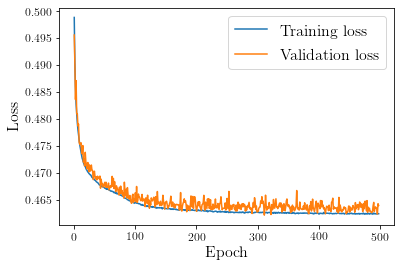

In [40]:
plt.plot(history['loss'][1:], label='Training loss')
plt.plot(history['val_loss'][1:], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/final_model_loss.pdf")

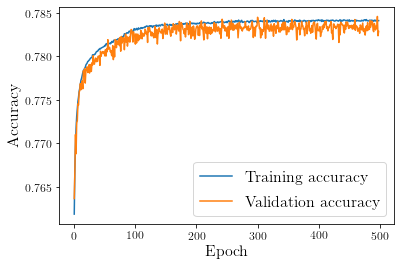

In [44]:
plt.plot(history['accuracy'][1:], label='Training accuracy')
plt.plot(history['val_accuracy'][1:], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/final_model_acc.pdf")

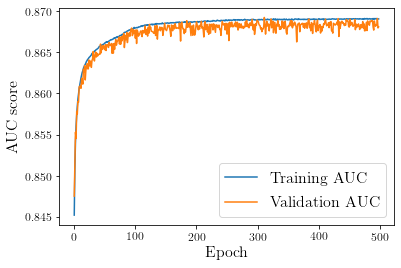

In [45]:
plt.plot(history['auc'][1:], label='Training AUC')
plt.plot(history['val_auc'][1:], label='Validation AUC')
plt.xlabel("Epoch")
plt.ylabel("AUC score")
plt.legend()
plt.savefig("images/final_model_auc.pdf")

In [63]:
print("Max accuraty             :", round(max(history['accuracy'])    , 4))
print("Max validation accuracy  :", round(max(history['val_accuracy']), 4))
print("Max AUC score            :", round(max(history['auc'])    , 4))
print("Max validation AUC score :", round(max(history['val_auc']), 4))

Max accuraty             : 0.7843
Max validation accuracy  : 0.7846
Max AUC score            : 0.8691
Max validation AUC score : 0.8692


In [66]:
print("Evaluation on the test set")
y_pred = model.predict(x_test).flatten()

Evaluation on the test set


In [67]:
#convert probabilities to class prediction
y_class = np.array(y_pred>0.5, dtype=np.int32)
#compute accuracy
print("Test accuracy: ", round(1-np.sum(np.abs(y_class-y_test))/len(y_test),4))
#compute AUC score
print("Test AUC scoure", round(roc_auc_score(y_test, y_pred) ,4))

Test accuracy:  0.7846
Test AUC scoure 0.8694


No Skill : ROC AUC=0.500
TTN model: ROC AUC=0.869


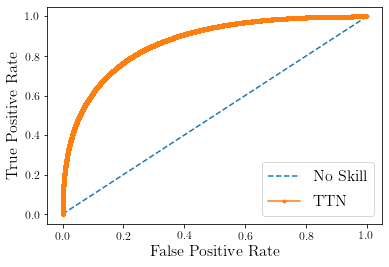

In [84]:
#print ROC Curve
ns_probs = [0 for _ in range(len(y_test))] #always zero model
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('No Skill : ROC AUC=%.3f' % (ns_auc))
print('TTN model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.',     label='TTN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("images/final_model_roc.pdf")
plt.show()

In [81]:
#plot confusion amtrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, 
                         name=""):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')#\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(name,bbox_inches='tight')
    plt.show()
    

In [82]:
cm = confusion_matrix(y_test, y_class)

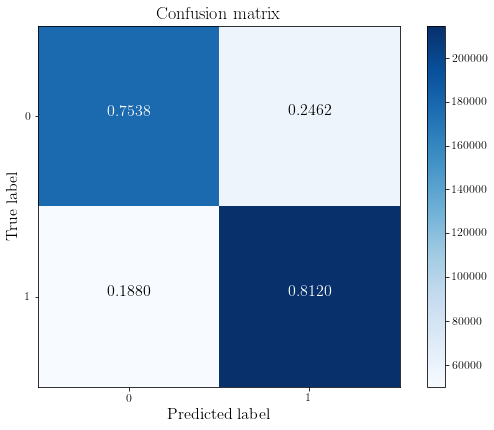

In [83]:
plot_confusion_matrix(cm, target_names=["0","1"], name="images/final_model_cm.pdf")